## 507 Final Project
### *Language in Flux: Temporal Semantic Change on Social Media*
Sualeha Farid (sualeha)

Setup

In [2]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
pip install --upgrade numpy gensim --force-reinstall

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp

In [1]:
# imports
import argparse
import pandas as pd
import networkx as nx
from collections import defaultdict
from itertools import combinations
import re
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
import gensim.downloader as api
from tqdm import tqdm
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
import spacy

In [2]:
# get stop word list for pre-processing
stop_words = set(stopwords.words('english'))

# for lemmatizer
nlp = spacy.load("en_core_web_sm")

# load model using api for embeddings
model = api.load("glove-twitter-200")

[==================================================] 100.0% 758.5/758.5MB downloaded


Functions for re-processing and building the graphs

In [12]:
def lemmatize_tweet(text):
    """Lemmatizes a tweet using the provided spacy NLP pipeline.

    Args:
        text (str): Raw tweet text

    Returns:
        str: A string of lemmatized words joined by space
    """
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def preprocess_tweet(tweet):
    """Cleans and tokenizes tweet text with lemmatization and filtering.

    Args:
        tweet (str): Raw tweet text

    Returns:
        list[str]: List of cleaned, lemmatized, and filtered tokens
    """
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"@\w+", "", tweet)
    tweet = re.sub(r"[^\w\s]", "", tweet)
    tweet = lemmatize_tweet(tweet)
    tokens = word_tokenize(tweet)
    return [word for word in tokens if word.isalpha() and word in model and word not in stop_words]

def build_embedding_graph_from_df(df, top_k=5, min_freq=10):
    """Constructs a semantic similarity graph using word embeddings from tweet data.

    Args:
        df (DataFrame): DataFrame containing a 'tweet' column
        top_k (int): Number of nearest neighbors to link per word
        min_freq (int): Minimum frequency for a word to be included in the graph

    Returns:
        networkx.Graph: Undirected graph where nodes are words and edges represent embedding similarity
    """
    word_freq = defaultdict(int)
    tokenized_tweets = []

    for tweet in df['tweet']:
        tokens = preprocess_tweet(tweet)
        tokenized_tweets.append(tokens)
        for word in tokens:
            word_freq[word] += 1

    vocab = {word for word, freq in word_freq.items() if freq >= min_freq}
    G = nx.Graph()

    for word in tqdm(vocab):
        G.add_node(word, freq=word_freq[word])
        try:
            similar_words = model.most_similar(word, topn=top_k)
            for neighbor, sim in similar_words:
                if neighbor in vocab:
                    G.add_edge(word, neighbor, weight=sim)
        except KeyError:
            continue

    return G

def build_cooccurrence_graph(df, min_freq=10):
    """Builds a word co-occurrence graph from tweets based on shared presence in a tweet.

    Args:
        df (DataFrame): DataFrame with a 'tweet' column
        min_freq (int): Minimum word frequency to keep in graph

    Returns:
        networkx.Graph: Graph where nodes are words and edges are weighted by co-occurrence count
    """
    G = nx.Graph()
    word_counts = defaultdict(int)

    for tweet in df['tweet']:
        tokens = preprocess_tweet(tweet)
        for w in tokens:
            word_counts[w] += 1
        for w1, w2 in combinations(set(tokens), 2):
            if G.has_edge(w1, w2):
                G[w1][w2]['weight'] += 1
            else:
                G.add_edge(w1, w2, weight=1)

    rare_words = {w for w, count in word_counts.items() if count < min_freq}
    G.remove_nodes_from(rare_words)
    return G


Load data and create graphs

In [6]:
df = pd.read_csv('/content/twitter_sample_2015_2023.csv')

# get years in a seperate column
df.sample(10)
df["year"] = df.date.str[:4]
df.year.value_counts() # to verify that i have 5000 tweets from each year.


,count
year,
2015,5000
2016,5000
2017,5000
2018,5000
2019,5000
2020,5000
2021,5000
2022,5000
2023,5000


In [7]:
df[df.year == "2015"].head()

,user,id,tweet,replies,retweets,likes,quotes,date,year
0,serenesuniverse,655822048908869632,Infinity Room at The Broad Museum: amazing ✨ h...,0,0,0,0,2015-10-18T19:05:35+00:00,2015
1,serenesuniverse,646860876109213696,Meeting Fik-Shun last night was unreal! Being ...,0,0,0,0,2015-09-24T01:37:05+00:00,2015
2,serenesuniverse,628640005523664896,Sakoma invites you to a celebration! Join us a...,0,0,0,0,2015-08-04T18:53:51+00:00,2015
3,serenesuniverse,623919450484572160,You read that right! Get 20% off at http://t.c...,0,0,0,0,2015-07-22T18:16:03+00:00,2015
4,serenesuniverse,621761438097494016,Spread the love! Get your waist beads today st...,0,0,0,0,2015-07-16T19:20:53+00:00,2015


In [8]:
df[df.year == "2019"].head()

,user,id,tweet,replies,retweets,likes,quotes,date,year
20000,MarketOne_Intl,1207244862065504257,We need more poems in the world of #B2B - http...,1,0,1,0,2019-12-18T10:22:59+00:00,2019
20001,MarketOne_Intl,1196734026784133120,"Right person, right message, right time, right...",0,0,3,0,2019-11-19T10:16:40+00:00,2019
20002,MarketOne_Intl,1193909069087723528,MarketOne is thrilled to announce that we have...,0,1,2,1,2019-11-11T15:11:18+00:00,2019
20003,MarketOne_Intl,1193908526864879618,It was a great talk! #ABM #B2Bconf https://t.c...,0,0,0,0,2019-11-11T15:09:09+00:00,2019
20004,MarketOne_Intl,1191730425397420039,@EmmaMoly @ProductHunt No. It's Giff :),0,0,0,0,2019-11-05T14:54:09+00:00,2019


In [15]:
# now create seperate similarity graohs for each year
g15 = build_embedding_graph_from_df(df[df.year == "2015"], min_freq=10)
g16 = build_embedding_graph_from_df(df[df.year == "2016"], min_freq=10)
g17 = build_embedding_graph_from_df(df[df.year == "2017"], min_freq=10)
g18 = build_embedding_graph_from_df(df[df.year == "2018"], min_freq=10)
g19 = build_embedding_graph_from_df(df[df.year == "2019"], min_freq=10)
g20 = build_embedding_graph_from_df(df[df.year == "2020"], min_freq=10)
g21 = build_embedding_graph_from_df(df[df.year == "2021"], min_freq=10)
g22 = build_embedding_graph_from_df(df[df.year == "2022"], min_freq=10)
g23 = build_embedding_graph_from_df(df[df.year == "2023"], min_freq=10)

100%|██████████| 618/618 [01:34<00:00,  6.55it/s]


In [16]:
# save sim graphs
nx.write_graphml(g15, "graph_2015.graphml")
nx.write_graphml(g16, "graph_2016.graphml")
nx.write_graphml(g17, "graph_2017.graphml")
nx.write_graphml(g18, "graph_2018.graphml")
nx.write_graphml(g19, "graph_2019.graphml")
nx.write_graphml(g20, "graph_2020.graphml")
nx.write_graphml(g21, "graph_2021.graphml")
nx.write_graphml(g22, "graph_2022.graphml")
nx.write_graphml(g23, "graph_2023.graphml")

In [17]:
# now build co-occurence graphs for each year
gc15 = build_cooccurrence_graph(df[df.year == "2015"], min_freq=10)
gc16 = build_cooccurrence_graph(df[df.year == "2016"], min_freq=10)
gc17 = build_cooccurrence_graph(df[df.year == "2017"], min_freq=10)
gc18 = build_cooccurrence_graph(df[df.year == "2018"], min_freq=10)
gc19 = build_cooccurrence_graph(df[df.year == "2019"], min_freq=10)
gc20 = build_cooccurrence_graph(df[df.year == "2020"], min_freq=10)
gc21 = build_cooccurrence_graph(df[df.year == "2021"], min_freq=10)
gc22 = build_cooccurrence_graph(df[df.year == "2022"], min_freq=10)
gc23 = build_cooccurrence_graph(df[df.year == "2023"], min_freq=10)

In [18]:
# save co-occurence graphs
nx.write_graphml(gc15, "cgraph_2015.graphml")
nx.write_graphml(gc16, "cgraph_2016.graphml")
nx.write_graphml(gc17, "cgraph_2017.graphml")
nx.write_graphml(gc18, "cgraph_2018.graphml")
nx.write_graphml(gc19, "cgraph_2019.graphml")
nx.write_graphml(gc20, "cgraph_2020.graphml")
nx.write_graphml(gc21, "cgraph_2021.graphml")
nx.write_graphml(gc22, "cgraph_2022.graphml")
nx.write_graphml(gc23, "cgraph_2023.graphml")

The remainder of this notebook is just some exploration of the graphs to see what is interesting and can be useful to show in the actual user-interface section (or the app - of sorts).

In [19]:
# g15.number_of_nodes()

centrality = nx.degree_centrality(g15)
top_words = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Most central words:", top_words)

Most central words: [('know', 0.02711323763955343), ('think', 0.022328548644338118), ('auch', 0.02073365231259968), ('next', 0.02073365231259968), ('ist', 0.017543859649122806), ('really', 0.017543859649122806), ('way', 0.017543859649122806), ('check', 0.01594896331738437), ('great', 0.01594896331738437), ('noch', 0.01594896331738437)]


In [20]:
centrality = nx.degree_centrality(g23)
top_words = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Most central words:", top_words)

Most central words: [('next', 0.027552674230145867), ('know', 0.022690437601296597), ('think', 0.022690437601296597), ('first', 0.01944894651539708), ('take', 0.01944894651539708), ('let', 0.017828200972447326), ('check', 0.01620745542949757), ('last', 0.01620745542949757), ('really', 0.01458670988654781), ('way', 0.01458670988654781)]


In [21]:
communities = list(greedy_modularity_communities(g15))
for i, comm in enumerate(communities[:5]):
    print(f"Community {i+1}: {list(comm)[:10]}")

Community 1: ['american', 'lord', 'pretty', 'friday', 'greeting', 'good', 'god', 'fun', 'late', 'amazing']
Community 2: ['feel', 'past', 'even', 'miss', 'bad', 'seem', 'may', 'think', 'remember', 'able']
Community 3: ['high', 'follow', 'move', 'support', 'winner', 'team', 'please', 'tell', 'basketball', 'enter']
Community 4: ['product', 'health', 'partner', 'relationship', 'company', 'family', 'education', 'exclusive', 'new', 'service']
Community 5: ['dans', 'fait', 'send', 'encore', 'à', 'au', 'plus', 'ce', 'il', 'pas']


In [22]:
communities = list(greedy_modularity_communities(g23))
for i, comm in enumerate(communities[:5]):
    print(f"Community {i+1}: {list(comm)[:10]}")

Community 1: ['high', 'next', 'part', 'schedule', 'lead', 'distance', 'second', 'series', 'point', 'new']
Community 2: ['push', 'ahead', 'follow', 'instant', 'move', 'support', 'please', 'save', 'across', 'hand']
Community 3: ['system', 'global', 'technology', 'museum', 'company', 'service', 'conference', 'startup', 'developer', 'digital']
Community 4: ['click', 'foundation', 'governance', 'entry', 'workshop', 'update', 'news', 'check', 'deal', 'available']
Community 5: ['bad', 'home', 'excellent', 'good', 'late', 'hard', 'amazing', 'tonight', 'work', 'enjoy']


In [23]:
path = nx.shortest_path(g15, source="work", target="day", weight="weight")
print("Path:", path)

path = nx.shortest_path(g20, source="work", target="day", weight="weight")
print("Path:", path)


Path: ['work', 'today', 'day']
Path: ['work', 'today', 'day']


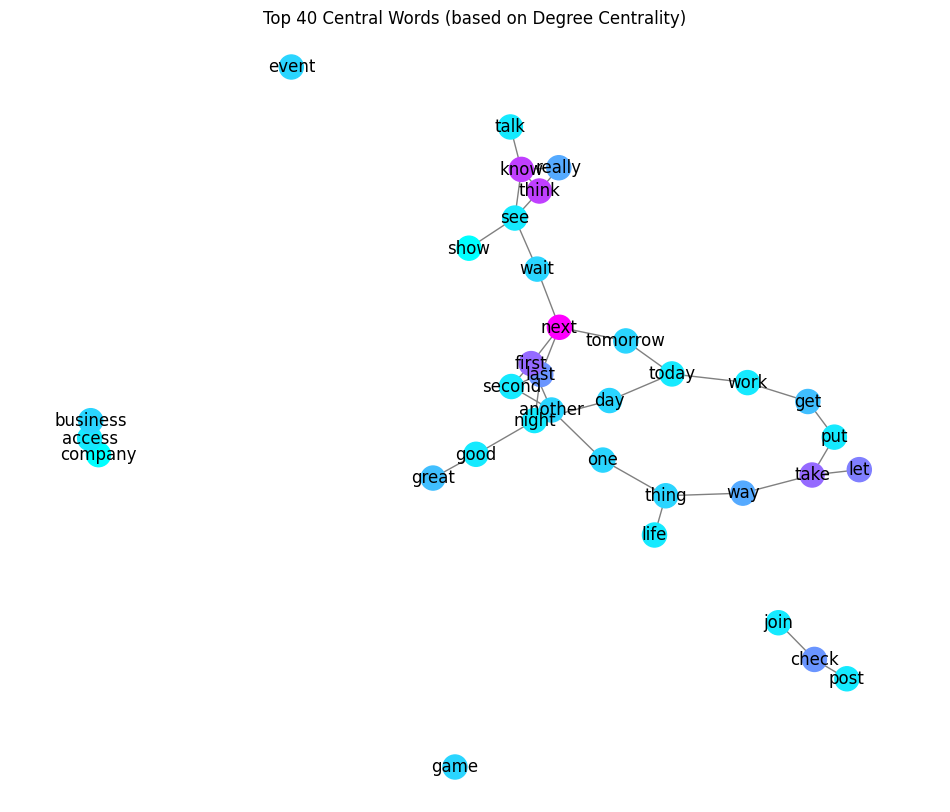

In [24]:
# Select top N central nodes
N = 40
top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:N]
top_node_names = [n for n, _ in top_nodes]
subG = g15.subgraph(top_node_names)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subG, seed=42)
node_color = [centrality[n] for n in subG.nodes()]
nx.draw_networkx(
    subG, pos,
    node_color=node_color,
    cmap=plt.cm.cool,
    with_labels=True,
    node_size=300,
    font_size=12,
    edge_color='gray'
)
plt.title("Top 40 Central Words (based on Degree Centrality)")
plt.axis('off')
plt.show()


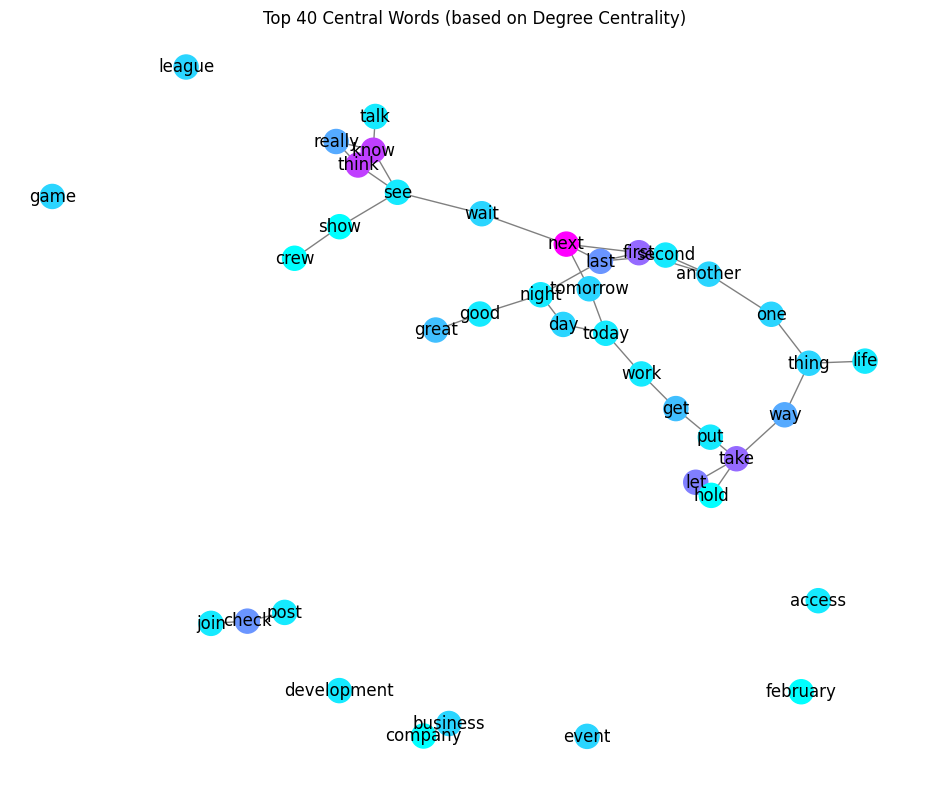

In [25]:
N = 40
top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:N]
top_node_names = [n for n, _ in top_nodes]
subG = g23.subgraph(top_node_names)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subG, seed=42)
node_color = [centrality[n] for n in subG.nodes()]
nx.draw_networkx(
    subG, pos,
    node_color=node_color,
    cmap=plt.cm.cool,
    with_labels=True,
    node_size=300,
    font_size=12,
    edge_color='gray'
)
plt.title("Top 40 Central Words (based on Degree Centrality)")
plt.axis('off')
plt.show()
